In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


**Загружаем датасет**

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 12s 0us/step


In [ ]:
test_img = x_test

**Данные содержат 50000 тренировочных изображений 32х32 и 10000 тестовых**

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

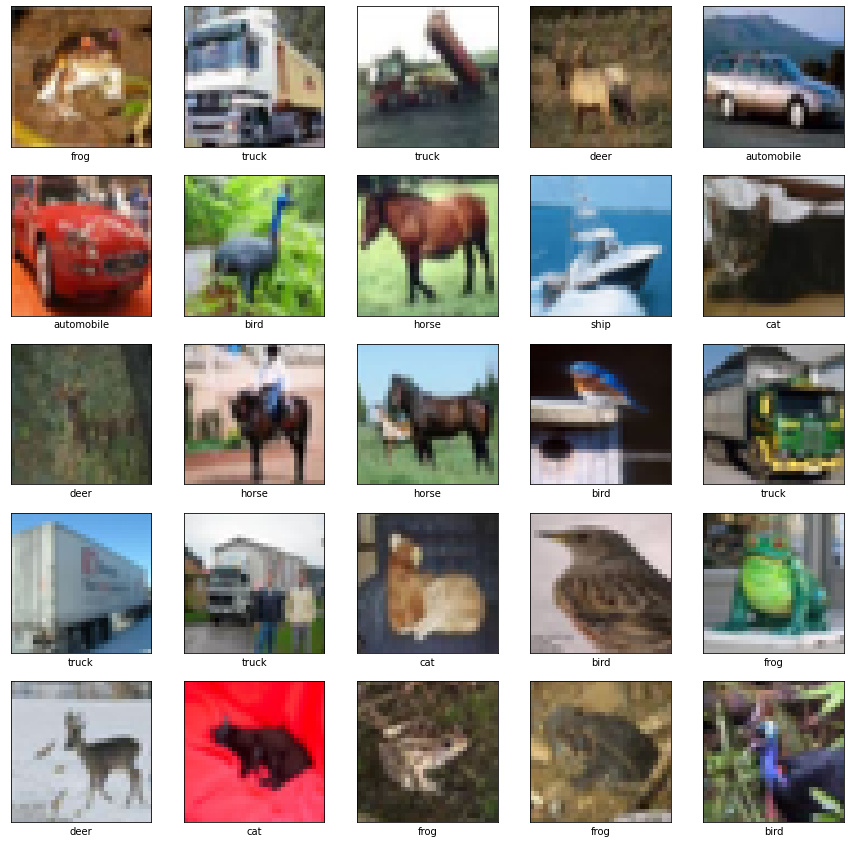

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_name[y_train[i][0]])
plt.show()

**VGG16**

In [ ]:
model = Sequential()
 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       7

**Предобработка данных**

In [ ]:
def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

In [ ]:
def normalize_production(x):
    #this function is used to normalize instances in production according to saved training set statistics
    # Input: X - a training set
    # Output X - a normalized training set according to normalization constants.

    #these values produced during first training and are general for the standard cifar10 training set normalization
    mean = 120.707
    std = 64.15
    return (x-mean)/(std+1e-7)

In [ ]:
def predict(x,normalize=True,batch_size=50):
    if normalize:
        x = normalize_production(x)
    return model.predict(x,batch_size)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
x_train, x_test = normalize(x_train, x_test)

In [ ]:
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
batch_size = 128
epochs = 50

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# The data, shuffled and split between train and test sets:

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).

datagen.fit(x_train)

In [ ]:
history = model.fit_generator(datagen.flow(
    x_train, y_train,
    batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
390/390 [==============================] - 73s 154ms/step - loss: 1.8955 - accuracy: 0.2749 - val_loss: 1.6617 - val_accuracy: 0.3460
Epoch 2/50
390/390 [==============================] - 58s 147ms/step - loss: 1.5475 - accuracy: 0.3994 - val_loss: 1.8780 - val_accuracy: 0.4364
Epoch 3/50
390/390 [==============================] - 57s 147ms/step - loss: 1.3646 - accuracy: 0.5002 - val_loss: 1.2687 - val_accuracy: 0.5644
Epoch 4/50
390/390 [==============================] - 57s 147ms/step - loss: 1.2064 - accuracy: 0.5745 - val_loss: 1.3517 - val_accuracy: 0.5750
Epoch 5/50
390/390 [==============================] - 58s 148ms/step - loss: 1.1179 - accuracy: 0.6204 - val_loss: 1.1945 - val_accuracy: 0.6383
Epoch 6/50
390/390 [==============================] - 58s 147ms/step - loss: 1.0203 - accuracy: 0.6583 - val_loss: 1.1137 - val_accuracy: 0.6585
Epoch 7/50
390/390 [==============================] - 58s 147ms/step - loss: 0.9770 - accuracy: 0.6766 - val_loss: 1.3509 - val_ac

**Точность предсказаний**

In [ ]:
preds = model.evaluate(x_test, y_test);
print("Testing Accuracy = %.2f %%" % (preds[1] * 100))

313/313 [==============================] - 6s 21ms/step - loss: 0.3674 - accuracy: 0.8936
Testing Accuracy = 89.36 %


In [ ]:
predicted_labels = model.predict(x_test)

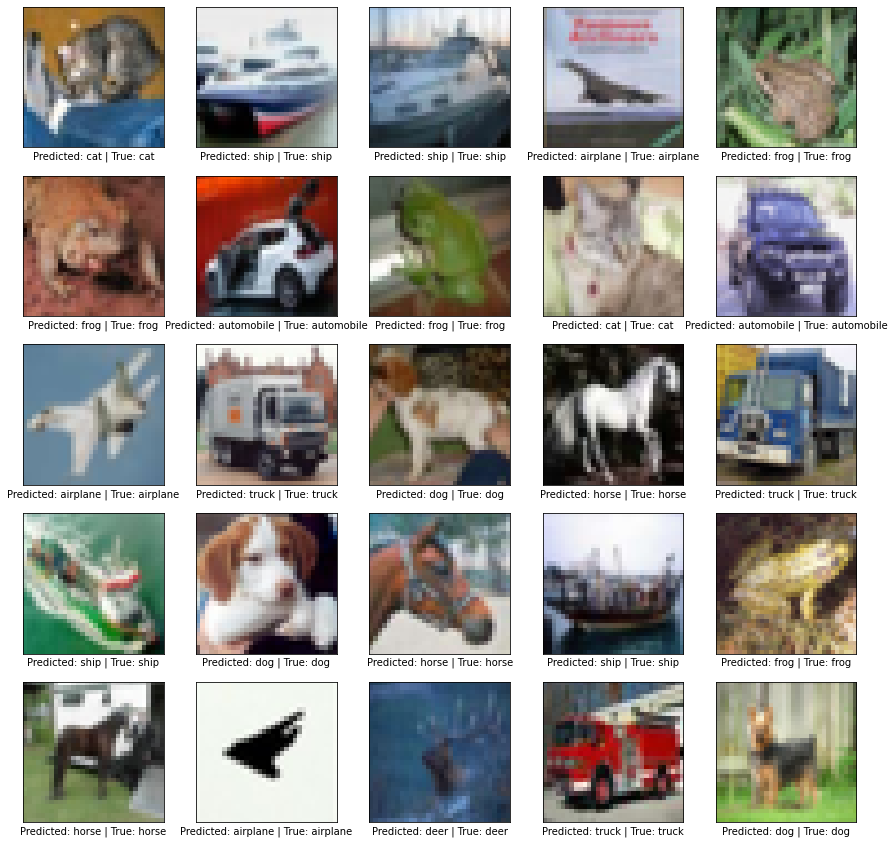

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_img[i], cmap=plt.cm.binary)
    plt.xlabel("Predicted: " + class_name[np.argmax([predicted_labels[i]])] + " | True: " + class_name[np.argmax([y_test[i]])])
plt.show()

<function matplotlib.pyplot.show>

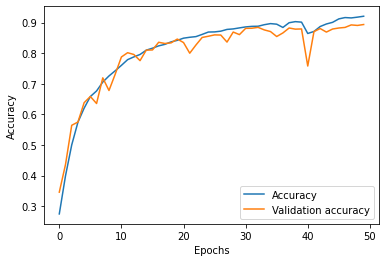

In [ ]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

**Тестирование предсказаний с нормальным и равномерным шумом**

**Нормальный шум**

In [ ]:
def apply_noise(img, SNR=5):
  # возведение каждого пикселя в квадрат (квадрат мощности сигнала)
  signal_power = np.square(img)
  # получение средней мощности сигнала
  signal_average_power = np.mean(signal_power)
  # максимальная амплитуда шума
  max_noise = signal_average_power / SNR
  # среднее значение шума
  mean_noise = 0
  # шум со средним значением = 0 и стандартным отклонением корень(шум)
  noise = np.random.normal(mean_noise, np.sqrt(max_noise), size = img.shape)
  # наложение шума на фото
  noised_img = img + noise
  return noised_img

In [ ]:
import random

img = test_img[random.randint(0, len(test_img)-1)]
img = np.expand_dims(img, axis=0)

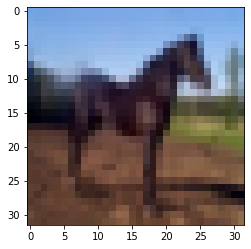

In [ ]:
plt.imshow(img[0])

In [ ]:
noised_img = apply_noise(img, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


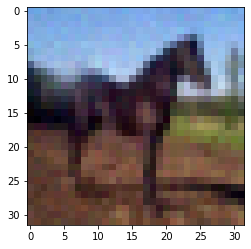

In [ ]:
img_to_show = noised_img.copy()
img_to_show /= 255
plt.imshow(img_to_show[0])

In [ ]:
def apply_noise_on_dataset(data):
  noisy_data = np.zeros((data.shape))
  i = 0
  for img in data:
    noisy_img = apply_noise(img, 5)
    noisy_data[i] = noisy_img
    i += 1
  return noisy_data

In [ ]:
# Создание генератора с шумом
noisy_generator = ImageDataGenerator(rescale=1./255)
noisy_generator = noisy_generator.flow(apply_noise_on_dataset(test_img), y_test, batch_size=128)

In [ ]:
(loss, accuracy) = model.evaluate(noisy_generator, verbose=1)
print("On noisy dataset accuracy is %.2f %%" % (accuracy * 100))

79/79 [==============================] - 3s 42ms/step - loss: 1.3084 - accuracy: 0.6048
On noisy dataset accuracy is 60.48 %


**Равномерный шум**

In [ ]:
def apply_uniform_noise(img, SNR=5):
  # возведение каждого пикселя в квадрат (квадрат мощности сигнала)
  signal_power = np.square(img)
  # получение средней мощности сигнала
  signal_average_power = np.mean(signal_power)
  # максимальная амплитуда шума
  max_noise = signal_average_power / SNR
  # среднее значение шума
  mean_noise = 0
  # шум со средним значением = 0 и стандартным отклонением корень(шум)
  noise = np.random.uniform(mean_noise, np.sqrt(max_noise), size = img.shape)
  # наложение шума на фото
  noised_img = img + noise
  return noised_img

In [ ]:
import random

img = test_img[random.randint(0, len(test_img)-1)]
img = np.expand_dims(img, axis=0)

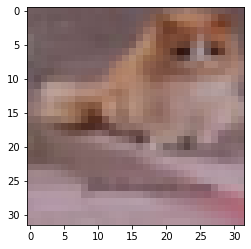

In [ ]:
plt.imshow(img[0])

In [ ]:
noised_img = apply_uniform_noise(img, 5)

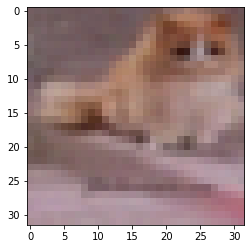

In [ ]:
img_to_show = noised_img.copy()
img_to_show /= 255
plt.imshow(img_to_show[0])

In [ ]:
def apply_uniform_noise_on_dataset(data):
  noisy_data = np.zeros((data.shape))
  i = 0
  for img in data:
    noisy_img = apply_uniform_noise(img, 5)
    noisy_data[i] = noisy_img
    i += 1
  return noisy_data

In [ ]:
# Создание генератора с шумом
noisy_generator = ImageDataGenerator(rescale=1./255)
noisy_generator = noisy_generator.flow(apply_uniform_noise_on_dataset(test_img), y_test, batch_size=128)

In [ ]:
(loss, accuracy) = model.evaluate(noisy_generator, verbose=1)
print("On noisy dataset accuracy is %.2f %%" % (accuracy * 100))

79/79 [==============================] - 3s 41ms/step - loss: 1.1957 - accuracy: 0.6297
On noisy dataset accuracy is 62.97 %
